In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import json
import re
import matplotlib
# import eunjeon

# 한글 품사 태깅을 위한 모듈
from konlpy.tag import Okt
from collections import Counter
from matplotlib import font_manager, rc
from wordcloud import WordCloud

plt.rcParams['font.family'] = 'NanumGothic'

# 구석구석_음식 DF 만들기
* '청계산', '이화여고100주년기념관', '곰달래꿈마을', '광야 서울', '문화철도 959' 제외 해야 함.

In [ ]:
### 'Category_Gusuk_Review_Final.csv' 사용함. ###
file = './data/Category_Gusuk_Review_Final.csv'

In [ ]:
# final.csv 열기
raw = pd.read_csv(file, encoding='cp949')
df = raw.copy()

print(df.shape)
df.head(2)

(910, 6)


,Attraction,Category,Subclass,Address,Tag,Participants
0,동대문역사문화공원,관광,"도시,테마공원",서울특별시 중구 신당동 853,#2024_여행가는달과함께하는_발도장여행지#DDP#가족여행#걷기좋은길#관광지#데이트...,56
1,서울식물원,관광,"식물원,수목원",서울특별시 강서구 마곡동로 161 서울식물원,#2024_여행가는달과함께하는_발도장여행지#가족과함께#관광지#교육여행#미세먼지_피하...,"5,204"


In [ ]:
# 아직 분류 전 food DF
df_food = df[df.Category == '음식']
df_food = df_food[['Attraction', 'Tag']].reset_index(drop=True)
df_food.head(2)

,Attraction,Tag
0,채그로,#독서#마포구가볼만한곳#복합문화시설#북카페#서울#쇼핑#채그로#책#힐링공간
1,소소한 풍경,#맛집#부암동맛집#부암동소소한풍경#부암동전망좋은식당#부암동한정식#소소한풍경#음식#전...


# 태그 전처리

In [ ]:
# 함수 만들기
def make_newTagCols(df, tag, i, total):
    tag = tag.split('#')[1:]
    df['newTag_list'][i] = tag

    words = ''
    for t in tag:
        words = words + t + ' '

    total = total + words + ' '

    df['newTag'][i] = words

    return df, total

In [ ]:
# 해시태그를 없앤 태그 리스트 컬럼 만들기
df_food[['newTag', 'newTag_list']] = None
total_words = ''

for i, tag in enumerate(df_food.Tag):
    df_food, total_words = make_newTagCols(df_food, tag, i, total_words)

In [ ]:
df_food.head(2)

,Attraction,Tag,newTag,newTag_list
0,채그로,#독서#마포구가볼만한곳#복합문화시설#북카페#서울#쇼핑#채그로#책#힐링공간,독서 마포구가볼만한곳 복합문화시설 북카페 서울 쇼핑 채그로 책 힐링공간,"[독서, 마포구가볼만한곳, 복합문화시설, 북카페, 서울, 쇼핑, 채그로, 책, 힐링공간]"
1,소소한 풍경,#맛집#부암동맛집#부암동소소한풍경#부암동전망좋은식당#부암동한정식#소소한풍경#음식#전...,맛집 부암동맛집 부암동소소한풍경 부암동전망좋은식당 부암동한정식 소소한풍경 음식 전망...,"[맛집, 부암동맛집, 부암동소소한풍경, 부암동전망좋은식당, 부암동한정식, 소소한풍경..."


In [ ]:
total_words

'독서 마포구가볼만한곳 복합문화시설 북카페 서울 쇼핑 채그로 책 힐링공간  맛집 부암동맛집 부암동소소한풍경 부암동전망좋은식당 부암동한정식 소소한풍경 음식 전망_좋은 퓨전한정식  관광지 남녀노소 맛집거리 서울맛집 숨은맛집 영등포가볼만한곳 음식거리 이색거리 이색음식 전국맛집 체험 홍어삼합 홍어회  골목식당 관광지 남녀노소 맛집 맛집골목 먹자골목 서울맛집 수도권 순대볶음 신림동맛집 신림동민속순대타운 신림동백순대 신림동순대타운 연인과함께 음식 이색거리 이색음식 친구와함께  떡볶이 마복림 마복림떡볶이 맛집 서울맛집추천 신당동떡볶이 신당동맛집 음식 즉석떡볶이  LP카페 가볼래터 뮤직카페 뮤직컴플렉스서울 여행구독 음식 음악카페 이색체험 이색카페 인사동가볼만한곳  또순이네 또순이네된장찌개 양평동또순이네 영등포또순이네 음식 주물럭맛집  갈비탕 고기맛집 관악구 꽁치김치찜 돼지낙지전골 돼지두부찌개 돼지두부찌개 돼지볶음 돼지볶음 맛집 서울맛집 서울우묵배미 서울한식당 신림역맛집 육개장 음식  과천산 관광지 관악산 서울대공원 서울청계산 자연 청룡산  맛집 삼계탕 음식 종로맛집 토속촌_오골계_삼계탕 토속촌삼계탕 해물파전  건강식맛집 건강여행 궁중수라 남녀노소 만세 맛집 부모님과함께 석파 수복 음식 전통음식 정성가득 종로구 진연 진찬 한정식 힐링여행  맛집 백년가게 불고기 서울시 음식 이북음식 종로구 평안도 한식 한정식  맛집 불고기덮밥 뽈떼기찜 뽈떼기탕 삼청동맛집 삼청동밥집 음식 제육볶음 종로맛집 홍합밥 홍합밥정식 홍합비빔밥  가족과함께 골목길 골목여행 관광지 낙지거리 낙지전문점 맛집골목 맛집탐방 숨은맛집 시장맛집 연인과함께 이색거리 전국맛집 체험 친구와함께  두부요리 두부요리전문점 두부한정식 두부한정식 만석장 맛집 백년가게 삼겹살가마구이 삼겹쌈밥 서울시 은평구 음식 정성가득  감자전 백년가게 보리밥 서울맛집 영양돌솥밥 음식  남녀노소 빈티지 사진찍기좋은곳 성동구 연인과함께 음식 정미소 카페 휴식공간 휴식하기좋은곳  단체모임추천 달개비 달개비한정식 맛집 서울시 서울시청맛집 서울중구맛집 

# 텍스트 마이닝

In [ ]:
# 함수
def extract_nouns(df, words, i):
    # 명사만 추출
    newTag_N = nlp.nouns(words)
    # 중복 제거
    newTag_N = list(set(newTag_N))
    # 리스트에 담기
    newTag_N_list.append(newTag_N)
    # 새로운 컬럼의 해당 행에 넣기
    df['tag_word_N'][i] = newTag_N

    return df

In [ ]:
# 'No_Tag'에서 명사 추출
# 관광지별로 구분하기
# 중복 명사 제거하기

# 한글 단어 구분하기
nlp = Okt()

newTag_N_list = []
df_food['tag_word_N'] = None


for i, words in enumerate(df_food['newTag']):
    df_food = extract_nouns(df_food, words, i)

In [ ]:
print(df_food.shape)
df_food.head(2)

(466, 5)


,Attraction,Tag,newTag,newTag_list,tag_word_N
0,채그로,#독서#마포구가볼만한곳#복합문화시설#북카페#서울#쇼핑#채그로#책#힐링공간,독서 마포구가볼만한곳 복합문화시설 북카페 서울 쇼핑 채그로 책 힐링공간,"[독서, 마포구가볼만한곳, 복합문화시설, 북카페, 서울, 쇼핑, 채그로, 책, 힐링공간]","[공간, 독서, 복합, 북카페, 마포구, 채, 쇼핑, 서울, 곳, 그로, 시설, 힐..."
1,소소한 풍경,#맛집#부암동맛집#부암동소소한풍경#부암동전망좋은식당#부암동한정식#소소한풍경#음식#전...,맛집 부암동맛집 부암동소소한풍경 부암동전망좋은식당 부암동한정식 소소한풍경 음식 전망...,"[맛집, 부암동맛집, 부암동소소한풍경, 부암동전망좋은식당, 부암동한정식, 소소한풍경...","[음식, 식당, 한정식, 맛집, 퓨전, 부암동, 풍경, 전망]"


## 태그 모은 것을 명사만 추출해서 확인

In [ ]:
# 태그 모은 것을 명사만 추출해서 확인하기
total_N = nlp.nouns(total_words)
print(f'중복 제거 전 : {len(total_N)}')

중복 제거 전 : 6279


In [ ]:
# 중복 제거
total_N_uniq = list(set(total_N))
print(f'중복 제거 후 : {len(total_N_uniq)}')

중복 제거 후 : 1314


In [ ]:
# 중복 제거한 것을 빈도 분석하기
count = Counter(total_N)
count

Counter({'맛집': 748,
         '음식': 476,
         '서울': 159,
         '카페': 91,
         '갈비': 67,
         '요리': 64,
         '한식': 60,
         '한우': 60,
         '추천': 50,
         '여행': 46,
         '정식': 44,
         '음식점': 44,
         '코스': 43,
         '한정식': 40,
         '분위기': 36,
         '수도권': 35,
         '칼국수': 34,
         '냉면': 33,
         '식당': 32,
         '구이': 32,
         '남녀': 30,
         '노소': 30,
         '위생': 30,
         '등급': 30,
         '가족': 28,
         '탕': 28,
         '등심': 28,
         '곳': 27,
         '중구': 27,
         '강남': 27,
         '휴식': 26,
         '연인': 25,
         '서울시': 25,
         '종로구': 24,
         '족발': 24,
         '스테이크': 24,
         '이색': 22,
         '불고기': 22,
         '맛': 22,
         '식사': 22,
         '생': 21,
         '종로': 20,
         '양념': 20,
         '레스토랑': 20,
         '만두': 19,
         '꽃': 19,
         '디저트': 18,
         '데이트': 18,
         '낙지': 17,
         '감성': 17,
         '중식': 17,
         '마포구': 15,

In [ ]:
# 단어와 빈도수로 DF 만들기
df_food_tag = \
pd.DataFrame(
    {'word' : list(count.keys()), 'count' : list(count.values())}
).sort_values('count', ascending=False).reset_index(drop=True)

print(df_food_tag.shape)
df_food_tag

(1314, 2)


,word,count
0,맛집,748
1,음식,476
2,서울,159
3,카페,91
4,갈비,67
...,...,...
1309,농산물,1
1310,축산물,1
1311,판매점,1
1312,산책,1


## 빈출단어 시각화하기

In [ ]:
# 상위 빈출 단어 80개 구하기
word_count = dict()

for tag, counts in count.most_common(80):
    if len(str(tag)) > 1:
        word_count[tag] = counts

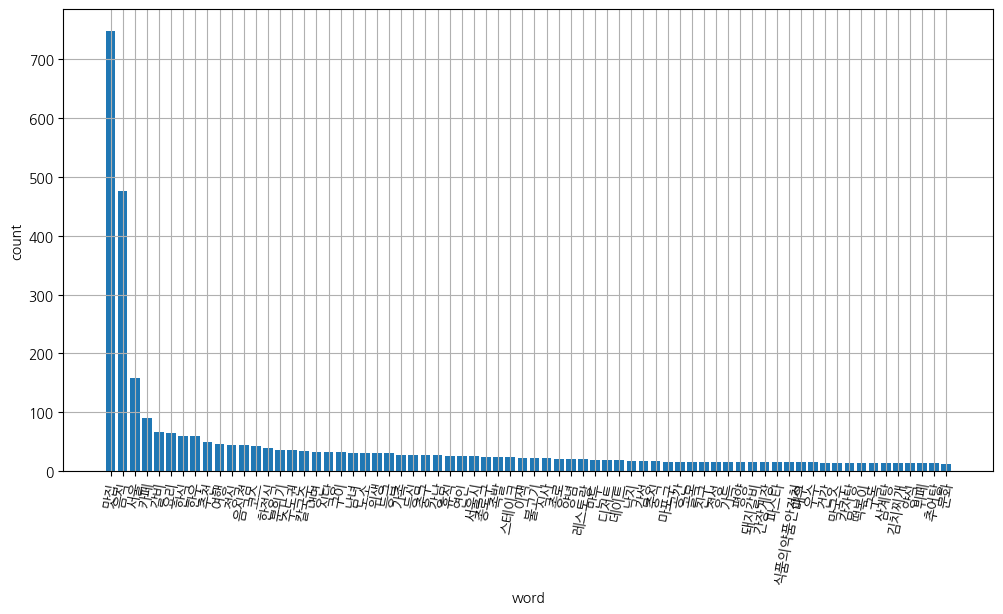

In [ ]:
# 시각화 준비
font_path = 'c:/Windows/Fonts/NanumGothic.ttf'

plt.figure(figsize=(12, 6))
plt.xlabel('word')
plt.ylabel('count')
plt.grid(True)

sorted_Keys = sorted(word_count, key=word_count.get, reverse=True)
sorted_Values = sorted(word_count.values(), reverse=True)

plt.bar(range(len(word_count)), sorted_Values, align='center')

plt.xticks(range(len(word_count)), list(sorted_Keys), rotation=80)
plt.show()

In [ ]:
# 저장하기
df_food_tag.to_csv('./data/food_tag.csv', index=False)

## 음식 카테고리 분류
* 논문의 유형으로 나누고
* 세부 항목들은 한국표준산업분류로 나눔.
    * 한, 중, 일, 서양, 그 외, 카페


In [ ]:
# 명사화 한 후 분류 한 것
# type 중복 허용 안했습니다.
# 호텔, 뷔페, 레스토랑, 다이닝 ==> etc
# Okt()로는 너무 나눠져서 뜻을 잃어버린 단어 넣어줌. --> 겹치는 거 제외하기 위해
##############################################
# '양장' (피가 나눠진 것이 있어서 양장만 넣음.)  '기사'  (한)'방차'  '해''담채'
##############################################

korean = \
[
    '갈비', '한우', '한식', '한정식', '칼국수', '냉면', '구이', '등심', '탕',
    '족발', '불고기', '만두', '낙지', '회', '평양', '돼지갈비', '간장게장', '복', '감자탕',
    '막국수', '떡볶이', '삼계탕', '추어탕', '김치찌개', '시장', '해장국', '볶음', '전골', '보쌈',
    '국수', '육회', '장어', '갈비살', '한식당', '비빔밥', '누룽지', '갈비탕', '백반',
    '쌈밥', '순대', '육개장', '전복', '삼겹살', '보양식', '매운탕', '만두전골',
    '곱창', '살', '수제비', '만둣국', '백숙', '떡갈비', '국밥', '만두국', '더덕', '버섯',
    '콩국수', '설렁탕', '메밀', '국', '찌개', '제육', '굴비', '쭈꾸미',
    '찜', '해산물', '파전', '비빔냉면', '생선회', '빈대떡', '수육', '보리', '청국장',
    '굴', '막창', '조림', '비빔국수', '소갈비', '녹두', '해물찜', '팥죽', '선지',
    '물냉면', '광장시장', '해물파전', '수라', '묵밥', '된장찌개', '홍어', '샤브샤브', '아구찜', '아귀찜',
    '갈비찜', '감자전', '능이', '육류', '불낙', '산삼', '추어', '홍어회', '순두부', '들깨',
    '복어', '차돌박이', '민물장어', '코다리', '우럭', '잡채', '삼치', '도가니탕', '산낙지', '사골',
    '국시', '떡', '닭갈비', '곱창전골', '매운갈비찜', '차돌', '도토리묵', '고기국수', '동그랑땡', '식혜',
    '옻', '닭칼국수', '횟집', '진어', '부채살', '닭볶음탕', '곰국', '김밥', '향토음식', '상차림', '전',
    '육전', '간', '복날', '모듬전', '해물탕', '철판', '회덮밥', '찹쌀', '장터', '떡국', '분식',
    '편육', '부대찌개', '전주', '홍어삼합', '김치', '꽁치', '메밀국수', '토속', '곰탕',
    '햄찜', '집밥', '메밀막국수', '샤부샤부', '전복죽', '생복탕', '냉칼국수', '찜닭', '장어구이', '복찜',
    '한치', '추탕', '데침', '껍데기', '가오리', '미꾸라지', '콩나물', '막걸리', '샤브', '전병',
    '명태', '소머리국밥', '도가니', '꼬리곰탕', '갯장어', '경주', '연포탕', '해물전', '계란찜',
    '죽', '석화', '닭발', '어묵', '해물뚝배기', '뚝배기', '제주', '치맛살', '수산시장', '알탕', '함흥',
    '가래떡', '여수', '바다장어', '신선로', '꽃살', '된장', '쫄면', '돌솥비빔밥', '산채', '통닭', '팥',
    '물만두', '장아찌', '황태', '비지', '치즈떡볶이', '메밀전', '복집', '보신탕', '돌솥밥',
    '보쌈김치', '술국', '옹심이', '보리밥', '순대볶음', '뽈떼기탕', '평안도', '뽈떼기찜', '복샤브',
    '동치미', '사찰음식', '산나물', '대게', '복탕', '돈육', '육계장', '메밀묵', '연잎밥', '두루치기',
    '두부김치', '천엽', '묵은지', '뼈찜', '장국밥','닭도리탕', '솥밥', '어탕', '냉삼', '선지국',
    '소갈비찜', '산채정식', '뭉티기', '수라상', '해삼', '기사', '돈가스', '돈까스', '대추차', '수정과',
    '한방차', '정육점', '해', '담채', '소주', '편백', '활어회'
]

chinese = \
[
    '중식', '짜장면', '탕수육', '짬뽕', '자장면', '딤섬', '중화요리', '중국집', '튀김',
    '북경오리', '샥스핀', '삼선짜장', '덕', '중국음식', '볶음밥', '바오', '우육', '오향', '어복',
    '훠궈', '삼선짬뽕', '전병', '난자완스', '꼬치', '중국요리', '면보샤', '삼선', '간짜장',
    '마파두부', '냉채', '굴짬뽕', '동파육', '양장', '해삼', '전복', '잡채', '오리고기',
    '양', '어향가', '하이디'
]

japanese = \
[
    '초밥', '일식', '해산물', '생선회', '우동', '함박스테이크', '스시', '회전초밥',
    '삿뽀로', '사시미', '튀김', '횟집', '슈치쿠', '회덮밥', '오뎅', '차슈', '키츠네', '라멘', '와사비',
    '교자', '어묵', '꼬치', '스키야키', '일본', '오코노미야끼', '타코야끼', '기스면', '회', '돈가스',
    '돈까스', '동경', '대게', '활어회'
]

west = \
[
    '스테이크', '파스타', '양식', '피자', '돈까스', '샐러드', '안심', '이탈리아음식', '치즈', '돈가스',
    '브런치', '립', '롤', '이탈리안', '크림', '리조또', '라자냐', '퐁듀', '타코',
    '비프', '이탈리아요리', '바베큐', '바비큐', '알리오', '켄싱턴', '트러플', '토마토', '바질', '라비올리',
    '아테네', '그리스', '멕시코', '브리또', '유럽', '프랑스', '칠리', '버터', '랍스터', '봉골레', '페투치',
    '뉴욕', '뉴욕뉴욕', '버거', '스파게티', '스페인', '그릴', '하몽', '이태리', '바게트', '그라탕',
    '이탈리아', '카놀리', '고르곤졸라', '프라이', '와인', '바', '위스키', '칵테일', '꼬냑'
]

etc = \
[
    '커리', '터키', '인도', '탄두리', '케밥', '태국', '얌꿍', '얌운센', '샥스핀', '월남쌈', '쌀국수',
    '베트남', '인도요리', '난', '칠리', '마샬', '코코넛', '카레라이스', '카레', '페르시안', '할랄',
    '팟타이', '꿍', '팟퐁', '쏨땀', '텃만꿍', '푸팟퐁', '몽골리안', '프라이', '호텔', '뷔페', '레스토랑', '다이닝'
]

cafe = \
[
    '카페', '디저트', '베이글', '커피', '샌드위치', '베이커리', '티', '케이크',
    '떡', '식혜', '카페라떼', '홍차', '빙수', '빵', '찻집', '북카페', '음료', '에스프레소',
    '슈페너', '차', '쿠키', '팥빙수', '스콘', '카푸치노', '드립', '드립카페', '마카롱', '가래떡',
    '팥', '아이스크림', '컴플렉스', '빵집', '떡집', '숍', '도넛', '한과', '흑임자', '생강차',
    '에그타르트', '제빵', '유자차', '티룸', '화과자', '아메리카노', '대추차', '수정과', '방차',
    '실내'
]

In [ ]:
foods = \
{
    'korean' : korean,
    'chinese' : chinese,
    'japanese' : japanese,
    'west' : west,
    'etc' : etc,
    'cafe' : cafe
}

# type 찾기

## type 개수 세기

In [ ]:
df_food_temp = df_food.copy()
df_food_temp = df_food_temp[['Attraction', 'tag_word_N']]
df_food_temp.head(2)

,Attraction,tag_word_N
0,채그로,"[공간, 독서, 복합, 북카페, 마포구, 채, 쇼핑, 서울, 곳, 그로, 시설, 힐..."
1,소소한 풍경,"[음식, 식당, 한정식, 맛집, 퓨전, 부암동, 풍경, 전망]"


In [ ]:
# Tag를 이용해서 어떤 subclass를 가지는지 확인하기
def check_foodType(df, tag_col, foodList, foodType):
    for i, tag in enumerate(df[tag_col]):
        for word in tag:
            if word in foodList:
                df[f'{foodType}'][i] += 1
    return df

In [ ]:
# food_type 컬럼 만들어서 빈도수 세기
df_food_temp[['korean', 'chinese', 'japanese', 'west', 'etc', 'cafe']] = 0

for type, food in foods.items():
    df_food_temp = check_foodType(df_food_temp, 'tag_word_N', food, type)

C:\Users\tjdtn\AppData\Local\Temp\ipykernel_7564\122418610.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{foodType}'][i] += 1
C:\Users\tjdtn\AppData\Local\Temp\ipykernel_7564\122418610.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{foodType}'][i] += 1
C:\Users\tjdtn\AppData\Local\Temp\ipykernel_7564\122418610.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{foodType}'][i] += 1
C:\Users\tjdtn\AppData\Local

In [ ]:
df_food_temp

,Attraction,tag_word_N,korean,chinese,japanese,west,etc,cafe
0,채그로,"[공간, 독서, 복합, 북카페, 마포구, 채, 쇼핑, 서울, 곳, 그로, 시설, 힐...",0,0,0,0,0,1
1,소소한 풍경,"[음식, 식당, 한정식, 맛집, 퓨전, 부암동, 풍경, 전망]",1,0,0,0,0,0
2,영등포 신길동 홍어거리,"[음식, 영등포, 홍어회, 관광지, 체험, 이색, 맛집, 서울, 곳, 홍어삼합, 거...",2,0,0,0,0,0
3,서울 신림동 민속순대타운,"[음식, 순대, 타운, 식당, 관광지, 친구, 이색, 골목, 민속, 맛집, 서울, ...",2,0,0,0,0,0
4,마복림할머니집,"[음식, 서울, 맛집, 추천, 마, 신당동, 복림, 떡볶이]",1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
461,해담채 삼성점,"[음식, 해, 코스, 맛집, 요리, 강남, 담채]",2,0,0,0,0,0
462,까사빠보,"[매우, 음식, 식품의약품안전처, 중구, 음식점, 위생, 등급, 맛집, 서울, 밥,...",1,0,1,0,0,0
463,포포인츠 바이 쉐라톤 조선 서울역 더 이터리,"[음식, 식품의약품안전처, 뷔페, 음식점, 위생, 등급, 맛, 맛집, 용산, 우수,...",0,0,0,0,1,0
464,오양회참치 광화문본점,"[음식, 회정, 분위기, 참다랑어, 맛집, 초밥, 회, 생복탕, 전복죽]",3,0,2,0,0,0


## type 생성

In [ ]:
# type 컬럼 만들기
df_food_temp[['max', 'type']] = None

In [ ]:
# max인 type 설정하기
df_food_temp['max'] = df_food_temp.iloc[:, 2:].max(axis=1)
df_food_temp['type'] = df_food_temp.iloc[:, 2:].idxmax(axis=1)

In [ ]:
df_food_temp.head(2)

,Attraction,tag_word_N,korean,chinese,japanese,west,etc,cafe,max,type
0,채그로,"[공간, 독서, 복합, 북카페, 마포구, 채, 쇼핑, 서울, 곳, 그로, 시설, 힐...",0,0,0,0,0,1,1,cafe
1,소소한 풍경,"[음식, 식당, 한정식, 맛집, 퓨전, 부암동, 풍경, 전망]",1,0,0,0,0,0,1,korean


In [ ]:
# max가 0인 Attraction의 type을 None으로 바꿔주기
df_food_temp[df_food_temp['max'] == 0] = df_food_temp[df_food_temp['max'] == 0].replace({'type':'korean'}, 'None')

In [ ]:
# type 넣은 것을 복사해서 사용하기
food_type = df_food_temp.copy()
food_type.head(2)

,Attraction,tag_word_N,korean,chinese,japanese,west,etc,cafe,max,type
0,채그로,"[공간, 독서, 복합, 북카페, 마포구, 채, 쇼핑, 서울, 곳, 그로, 시설, 힐...",0,0,0,0,0,1,1,cafe
1,소소한 풍경,"[음식, 식당, 한정식, 맛집, 퓨전, 부암동, 풍경, 전망]",1,0,0,0,0,0,1,korean


## 타입별로 확인해보기

In [ ]:
# 타입별 개수 확인하는 함수
def typeCount(df, col_name):
    n = df[df.type == f'{col_name}'].shape[0]
    print(f'{col_name} type : {n}개')

In [ ]:
for type in foods.keys():
    typeCount(food_type, type)

korean type : 273개
chinese type : 28개
japanese type : 17개
west type : 37개
etc type : 17개
cafe type : 50개


In [ ]:
# food_type[food_type.foodType == 'etc']

### MAX가 2개 이상인 Attraction 확인

In [ ]:
# MAX가 2개 이상인 행 추출해서 새로운 DF 만들기
def max_duplicate(new_df, df, col_name):
    condition = (df['max'] != 0) & (df['max'] == df[f'{col_name}']) & (df.type != f'{col_name}')
    df_ = df[condition]
    print(f'Max가 {col_name} type 말고 다른 type도 있는 Attraction 수 : {df_.shape[0]}개')

    new_df = pd.concat([new_df, df_])
    new_df.drop_duplicates(subset=['Attraction'], inplace=True)
    return new_df

In [ ]:
# max가 2개 이상인 attraction을 담는 DF
max_duplicate_df = \
pd.DataFrame(columns=['Attraction', 'tag_word_N', 'korean', 'chinese', 'japanese', 'west','etc', 'cafe', 'max', 'type'])

max_duplicate_df

,Attraction,tag_word_N,korean,chinese,japanese,west,etc,cafe,max,type


In [ ]:
for food in foods.keys():
    max_duplicate_df = max_duplicate(max_duplicate_df, food_type, food)
    n = max_duplicate_df.shape[0]

print(f'max type이 2개 이상인 총 attraction 수 : {n}개')

Max가 korean type 말고 다른 type도 있는 Attraction 수 : 0개
Max가 chinese type 말고 다른 type도 있는 Attraction 수 : 0개
Max가 japanese type 말고 다른 type도 있는 Attraction 수 : 5개
Max가 west type 말고 다른 type도 있는 Attraction 수 : 2개
Max가 etc type 말고 다른 type도 있는 Attraction 수 : 6개
Max가 cafe type 말고 다른 type도 있는 Attraction 수 : 2개
max type이 2개 이상인 총 attraction 수 : 15개


In [ ]:
print(max_duplicate_df.shape)
max_duplicate_df

(15, 10)


,Attraction,tag_word_N,korean,chinese,japanese,west,etc,cafe,max,type
156,다래함박스텍,"[음식, 식당, 다래, 맛집, 유리기, 기사, 함박스테이크, 가성, 돈가스, 비식]",2,0,2,1,0,0,2,korean
232,또순이,"[음식, 맛집, 동작구, 노량진, 생선회]",1,0,1,0,0,0,1,korean
298,진남회집,"[음식, 소주, 친구, 맛집, 동작구, 요리, 한잔, 초밥, 회]",2,0,2,0,0,0,2,korean
411,신강양꼬치,"[음식, 꼬치, 맛집]",0,1,1,0,0,0,1,chinese
462,까사빠보,"[매우, 음식, 식품의약품안전처, 중구, 음식점, 위생, 등급, 맛집, 서울, 밥,...",1,0,1,0,0,0,1,korean
70,쭈꾸미킹2.0 상봉점,"[음식, 피자, 직화, 킹, 맛집, 상봉동, 쭈꾸미, 중랑구]",1,0,0,1,0,0,1,korean
135,금왕돈까스,"[음식, 소개, 금, 생선, 언론, 서울시, 맛집, 성북구, 심, 함박스테이크, 돈...",1,0,2,2,0,0,2,japanese
31,이화여고100주년기념관,"[주년, 정동, 이화여고, 서대문, 프라이, 홀, 시설, 기념관, 공연장, 문화]",0,0,0,1,1,0,1,west
107,여의도백리향,"[음식, 식당, 분위기, 다이닝, 중국음식, 코스, 맛집, 여의도, 요리, 가족, ...",0,1,0,0,1,0,1,chinese
206,정식당,"[음식, 다이닝, 코스, 맛집, 요리, 가족, 한식, 연인, 정식]",1,0,0,0,1,0,1,korean


### type이 None인 Attraction

In [ ]:
print(food_type[food_type.type == 'None'].shape)

(44, 10)


In [ ]:
food_type_None = food_type[food_type.type == 'None'].reset_index(drop=True)
food_type_None

,Attraction,tag_word_N,korean,chinese,japanese,west,etc,cafe,max,type
0,청계산,"[산, 공원, 관광지, 서울대, 청계산, 관악산, 서울, 청룡, 자연, 과천]",0,0,0,0,0,0,0,None
1,꽃새우 영번지,"[음식, 맛집]",0,0,0,0,0,0,0,None
2,계림식당,"[음식, 맛집]",0,0,0,0,0,0,0,None
3,꽃밥에피다,"[음식, 황경, 건강, 여행, 맛집, 힐링, 친, 연인]",0,0,0,0,0,0,0,None
4,중구 송원,"[음식, 맛집]",0,0,0,0,0,0,0,None
5,봉래헌(메이필드호텔),"[음식, 맛집]",0,0,0,0,0,0,0,None
6,문화철도 959,"[공간, 복합, 휴식, 관광지, 곳, 종합예술, 아이, 예술, 문화]",0,0,0,0,0,0,0,None
7,곰달래꿈마을,"[휴식, 관광지, 사진, 감성, 골목, 투어, 여행, 휴양, 산책, 곳, 힐링, 찍...",0,0,0,0,0,0,0,None
8,인사동그집,"[음식, 맛집]",0,0,0,0,0,0,0,None
9,곰국시집 명동,"[음식, 맛집]",0,0,0,0,0,0,0,None


In [ ]:
# 타입 나눈거 일단 csv로 만들기
food_type.to_csv('./data/food_type.csv', index=False)

명사로 나누기 전으로 해보려고 했는데 그렇게 해도 많이 나눠지지 않을 것 같아 네이버 midclass를 이용해야할 것 같다는 생각을 함. --> 특정단어는 타입에 넣어주면 조금 나눠질 것 같음

### 분류가 제대로 되지 않은 것을 직접 확인하는 작업
* 네이버 subclass, 기존 tag를 확인해서 전 작업이 제대로 되었는지 확인하기

In [ ]:
# type이 None인 관광지 확인
pd.merge(food_type_None, df, on='Attraction')[['Attraction', 'Subclass', 'Address', 'Tag']]

,Attraction,Subclass,Address,Tag
0,청계산,돼지고기구이,서울특별시 서초구 청계산로 434,#과천산#관광지#관악산#서울대공원#서울청계산#자연#청룡산
1,꽃새우 영번지,"해물,생선요리",서울특별시 강남구 언주로 536,#맛집#음식
2,계림식당,닭볶음탕,서울특별시 종로구 돈화문로4길 39,#맛집#음식
3,꽃밥에피다,한식,서울특별시 종로구 인사동16길 3-6,#건강식#건강식맛집#건강여행#건강음식#건강한힐링여행#연인과함께#음식#친황경#친황경여...
4,중구 송원,한식,서울특별시 중구 동호로24길 35-4,#맛집#음식
5,봉래헌(메이필드호텔),한정식-일반,서울특별시 강서구 방화대로 94 메이필드호텔 봉래헌,#맛집#음식
6,문화철도 959,"키즈카페,실내놀이터","서울특별시 구로구 경인로 688 1호선 신도림역 2층, 3층",#관광지#문화공간#문화예술#복합문화공간#아이와함께#종합예술#휴식공간#휴식하기#휴식하...
7,곰달래꿈마을,"카페,디저트",서울특별시 양천구 곰달래로 36,#SNS감성사진#골목여행#골목투어#관광지#사진찍기좋은곳#산책하기좋은곳#연인과함께#휴...
8,인사동그집,한식,서울특별시 종로구 인사동12길 3 인사동그집,#맛집#음식
9,곰국시집 명동,국수,서울특별시 중구 무교로 24 2층,#맛집#음식


In [ ]:
# max가 두개 이상인 관광지 확인
pd.merge(max_duplicate_df, df, on='Attraction')[['Attraction', 'Subclass', 'Address', 'Tag']]

,Attraction,Subclass,Address,Tag
0,다래함박스텍,돈가스,서울특별시 강북구 수유로 20-2,#가성비식당#기사식당돈가스#다래함박스테이크#돈가스맛집#수유리기사식당#음식#함박스테이크맛집
1,또순이,한식,서울특별시 종로구 경희궁길 18 안성또순이,#노량진맛집#동작구맛집#맛집#생선회#음식
2,진남회집,생선회,서울특별시 동작구 노들로 674 노량진수산시장 2층 13호,#건강한요리#건강한음식#동작구#동작구맛집#맛집#소주한잔#음식#초밥#친구와함께#회#회맛집
3,신강양꼬치,양꼬치,서울특별시 마포구 토정로37길 21,#맛집#양꼬치#음식
4,까사빠보,일식당,서울특별시 중구 소공로 63 본관 6층,#민물장어덮밥#서울중구맛집#식품의약품안전처_음식점위생등급_매우우수(2017년)#음식...
5,쭈꾸미킹2.0 상봉점,주꾸미요리,서울특별시 중랑구 송림길 13,#상봉동맛집#음식#중랑구 쭈꾸미킹2.0#직화쭈꾸미#쭈꾸미맛집#쭈꾸미킹2.0#쭈꾸미피자
6,금왕돈까스,돈가스,서울 성북구 성북로 138,#금왕정식#돈까스#맛집#생선까스#서울시#성북구#심돈까스#안심돈까스#음식#함박스테이크...
7,이화여고100주년기념관,"카페,디저트",서울특별시 중구 정동길 26 이화여고100주년기념관,#100주년기념관#공연장#문화시설#서대문공연장#이화여고#이화여고100주년기념관#이화...
8,여의도백리향,중식당,서울특별시 영등포구 63로 50 한화금융센터_63 57층,#63빌딩다이닝#63빌딩중식당#맛집#분위기_좋은가족식사_추천#여의도맛집#여의도중국음...
9,정식당,한식,서울특별시 강남구 선릉로158길 11,#가족과함께#맛집#연인과함께#음식#정식당#코스요리#파인다이닝#한식


## foodType 업데이트 후 csv 저장하기
* 확인 필요한 것은 csv 파일 다운받아 직접 변경해줌.
* 최종 DF : food_type_v2.csv

In [ ]:
food_type2 = pd.read_csv('./data/food_type_v2.csv')
print(food_type2.shape)
food_type2.head(2)

(461, 10)


,Attraction,tag_word_N,korean,chinese,japanese,west,etc,cafe,max,type
0,채그로,"['공간', '독서', '복합', '북카페', '마포구', '채', '쇼핑', '서...",0,0,0,0,0,1,1,cafe
1,소소한 풍경,"['음식', '식당', '한정식', '맛집', '퓨전', '부암동', '풍경', '...",1,0,0,0,0,0,1,korean


In [ ]:
# type에 None이 있나 확인
food_type2[food_type2.type == 'None']

,Attraction,tag_word_N,korean,chinese,japanese,west,etc,cafe,max,type


--------------
# 머신러닝
* classify_food_df의 midclass와 subclass와 비교하기
* food_type2의 type을 y로 두고 했습니다.

## 전처리

In [ ]:
# 태영님 분류 DF에서 음식 카테고리의 Attraction, midclass, subclass, Tag 가져오기
classify_raw = pd.read_csv('./data/카테고리3분류.csv', encoding='cp949')
classify_df = classify_raw.copy()

classify_food_df = classify_df[classify_df.Category == '음식'][['Attraction', 'Midclass', 'Subclass']]
classify_food_df.head(2)

,Attraction,Midclass,Subclass
48,채그로,카페,북카페
56,소소한 풍경,한식,한식


In [ ]:
# 로지스틱 회귀를 위한 DF 만들기
# df1 : food_type~
# df2 : classify_food_df

def makeDF(raw1, df2):
    df1 = raw1.copy()
    df1 = df1[['Attraction', 'type']]
    df = pd.merge(df1, df2, on='Attraction')
    return df

In [ ]:
# 위의 두 데이터 병합
df_check = makeDF(food_type2, classify_food_df)
print(df_check.shape)
df_check.head(2)

(461, 4)


,Attraction,type,Midclass,Subclass
0,채그로,cafe,카페,북카페
1,소소한 풍경,korean,한식,한식


## 로지스틱 회귀
* foodType을 정답이라고 생각하고 돌리기

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

* Midclass

In [ ]:
# 데이터 분할
X_train, X_test, y_train, y_test = \
train_test_split(df_check['Midclass'], df_check['type'], test_size=0.2, random_state=91) # 8 : 92% / 46 : 91% / 52,53,58,60 : 92% / 91 : 94.6%

# 텍스트 데이터를 TF-IDF 벡터로 변환
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 로지스틱 회귀 모델 학습하기
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# 예측하기
y_pred = model.predict(X_test_tfidf)

# 평가
print('Accuracy :', accuracy_score(y_test, y_pred))
print('Classification Report\n', classification_report(y_test, y_pred))

Accuracy : 0.946236559139785
Classification Report
               precision    recall  f1-score   support

        cafe       1.00      0.86      0.92        14
     chinese       1.00      1.00      1.00         8
         etc       1.00      1.00      1.00         5
    japanese       0.50      1.00      0.67         2
      korean       0.98      0.95      0.97        59
        west       0.71      1.00      0.83         5

    accuracy                           0.95        93
   macro avg       0.87      0.97      0.90        93
weighted avg       0.96      0.95      0.95        93



In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# 데이터 분할
X_train, X_test, y_train, y_test = \
train_test_split(df_check['Midclass'], df_check['type'], test_size=0.2, random_state=91)

# 텍스트 데이터를 TF-IDF 벡터로 변환
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 하이퍼파라미터튜닝
param_grid = {
    'C' : [0.01, 0.1, 1, 10, 100],
    'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

# 최적모델로 예측하기
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_tfidf)

# 평가
print('Best Parameters :', grid_search.best_params_)
print('Accuracy :', accuracy_score(y_test, y_pred))
print('Classification Report\n', classification_report(y_test, y_pred))

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

Best Parameters : {'C': 1, 'solver': 'lbfgs'}
Accuracy : 0.946236559139785
Classification Report
               precision    recall  f1-score   support

        cafe       1.00      0.86      0.92        14
     chinese       1.00      1.00      1.00         8
         etc       1.00      1.00      1.00         5
    japanese       0.50      1.00      0.67         2
      korean       0.98      0.95      0.97        59
        west       0.71      1.00      0.83         5

    accuracy                           0.95        93
   macro avg       0.87      0.97      0.90        93
weighted avg       0.96      0.95      0.95        93



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


* Subclass

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# 데이터 분할
X_train, X_test, y_train, y_test = \
train_test_split(df_check['Subclass'], df_check['type'], test_size=0.2, random_state=87) # 8, 55 : 92% / 46 : 91% / 66, 71 : 93.5% / 87 : 94.6%

# 텍스트 데이터를 TF-IDF 벡터로 변환
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 로지스틱 회귀 모델 학습하기
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# 예측하기
y_pred = model.predict(X_test_tfidf)

# 평가
print('Accuracy :', accuracy_score(y_test, y_pred))
print('Classification Report\n', classification_report(y_test, y_pred))

Accuracy : 0.946236559139785
Classification Report
               precision    recall  f1-score   support

        cafe       1.00      0.86      0.92         7
     chinese       1.00      0.50      0.67         2
         etc       0.00      0.00      0.00         1
    japanese       1.00      0.50      0.67         2
      korean       0.94      1.00      0.97        72
        west       1.00      0.89      0.94         9

    accuracy                           0.95        93
   macro avg       0.82      0.62      0.69        93
weighted avg       0.94      0.95      0.94        93



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# 데이터 분할
X_train, X_test, y_train, y_test = \
train_test_split(df_check['Subclass'], df_check['type'], test_size=0.2, random_state=87)

# 텍스트 데이터를 TF-IDF 벡터로 변환
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 하이퍼파라미터튜닝
param_grid = {
    'C' : [0.01, 0.1, 1, 10, 100],
    'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

# 최적모델로 예측하기
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_tfidf)

# 평가
print('Best Parameters :', grid_search.best_params_)
print('Accuracy :', accuracy_score(y_test, y_pred))
print('Classification Report\n', classification_report(y_test, y_pred))

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

Best Parameters : {'C': 10, 'solver': 'lbfgs'}
Accuracy : 0.946236559139785
Classification Report
               precision    recall  f1-score   support

        cafe       0.86      0.86      0.86         7
     chinese       1.00      0.50      0.67         2
         etc       1.00      1.00      1.00         1
    japanese       0.50      1.00      0.67         2
      korean       0.97      0.96      0.97        72
        west       1.00      1.00      1.00         9

    accuracy                           0.95        93
   macro avg       0.89      0.89      0.86        93
weighted avg       0.96      0.95      0.95        93



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
